In [290]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import time
import yaml
import os
import torch

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-06-27 18:51:57.490452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 18:51:57.491162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 18:51:57.491254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15374359981250499429
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10735779840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16755277244642182127
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

# Dummy

In [9]:
action = np.load('data/preprocessed/MountainCar-v0/expert_data_1/cluster/data_0/action_0.02_1.npy')
delta_s = np.load('data/preprocessed/MountainCar-v0/expert_data_1/cluster/data_0/delta_s_0.02.npy')

In [10]:
len(action)

352382

([<matplotlib.axis.XTick at 0x75a103af2020>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

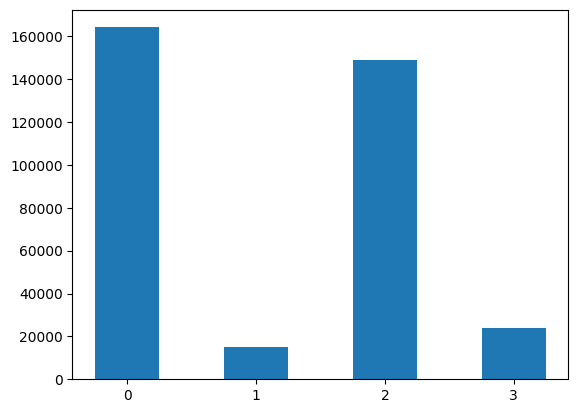

In [121]:
values, counts = np.unique(action, return_counts=True)

plt.bar(values, counts, width = 0.5, align='center')
plt.xticks([0,1,2,3])

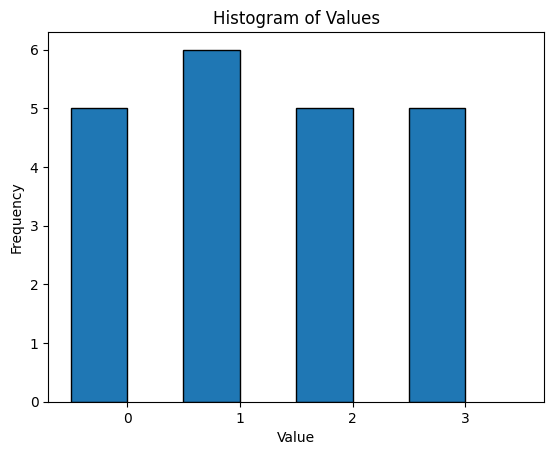

In [117]:
import matplotlib.pyplot as plt

# 데이터 생성
data = [0, 1, 2, 3, 1, 2, 1, 0, 3, 3, 2, 1, 0, 1, 2, 3, 0, 0, 1, 3, 2]

# 히스토그램 그리기
plt.hist(data, bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black', width = 0.5)

# x축 레이블 설정
plt.xticks([0, 1, 2, 3])

# 그래프 보여주기
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


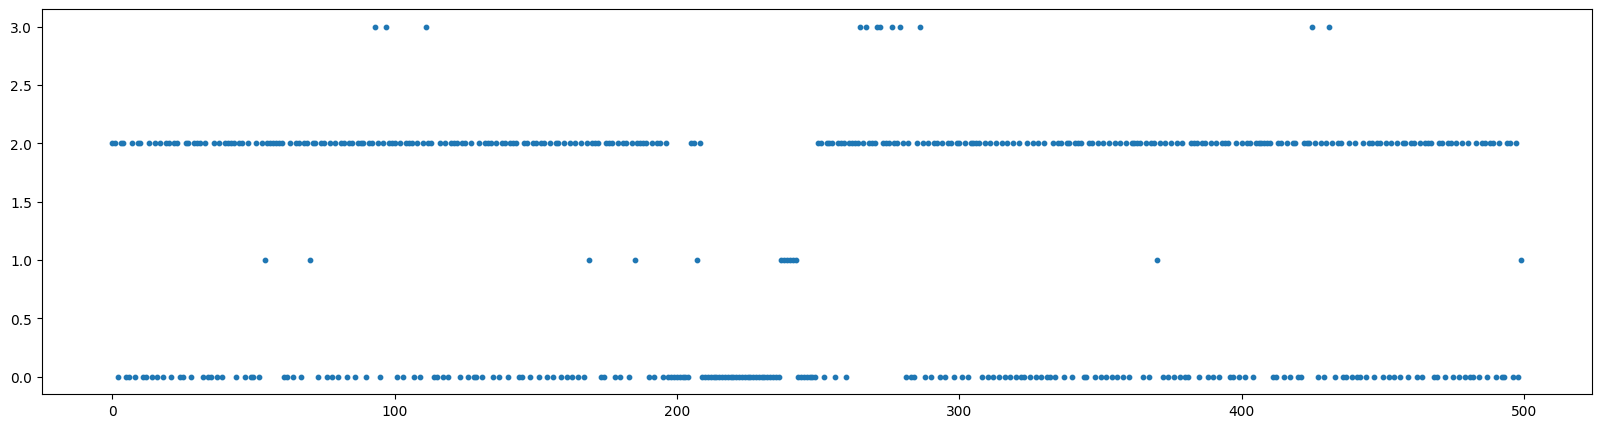

In [95]:
plt.figure(figsize=(20,5))
plt.scatter(np.arange(0, len(action[2000:2500])), action[2000:2500], s = 10)

In [11]:
len(delta_s)

352382

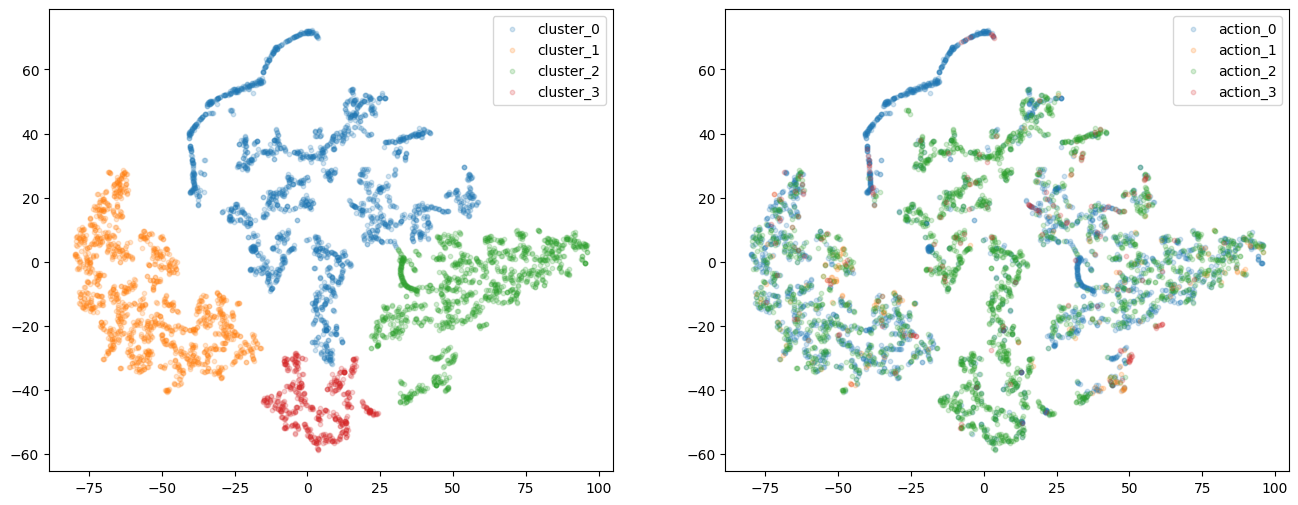

In [131]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering

num_c = 4

tsne = TSNE(n_components=2, perplexity=30)
delta_s_r = tsne.fit_transform(delta_s[:5000, [0,2,4]])

kmeans = AgglomerativeClustering(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s_r)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for n in range(num_c):
    idx = np.where(result == n)
    plt.scatter(delta_s_r[idx,0], delta_s_r[idx,1], s=10, alpha=0.2, label=f'cluster_{n}')
plt.legend()

plt.subplot(1,2,2)
n_action = len(np.unique(action))
for n in range(n_action):
    idx = np.where(action[:5000] == n)
    plt.scatter(delta_s_r[idx,0], delta_s_r[idx,1], s=10, alpha=0.2, label=f'action_{n}')
plt.legend()

In [65]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering

num_c = 4

tsne = TSNE(n_components=3, perplexity=30)
delta_s_r = tsne.fit_transform(delta_s[:1000])

kmeans = AgglomerativeClustering(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s_r)

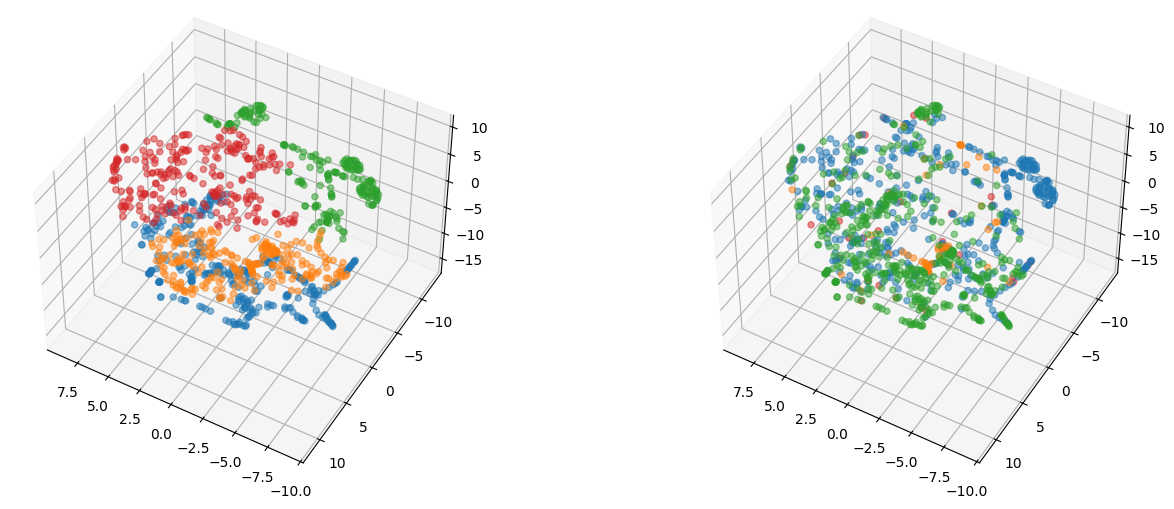

In [66]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121, projection='3d')
for n in range(num_c):
    idx = np.where(result == n)
    ax.scatter(delta_s_r[idx,0], delta_s_r[idx,1], delta_s_r[idx,2], alpha=0.5, label=f'cluster_{n}')
# plt.legend()
ax.view_init(elev=45., azim=120)

ax = fig.add_subplot(122, projection='3d')
n_action = len(np.unique(action))
for n in range(n_action):
    idx = np.where(action[:1000] == n)
    ax.scatter(delta_s_r[idx,0], delta_s_r[idx,1], delta_s_r[idx,2], alpha=0.5, label=f'action_{n}')
# plt.legend()
ax.view_init(elev=45., azim=120)

(-0.05, 0.05)

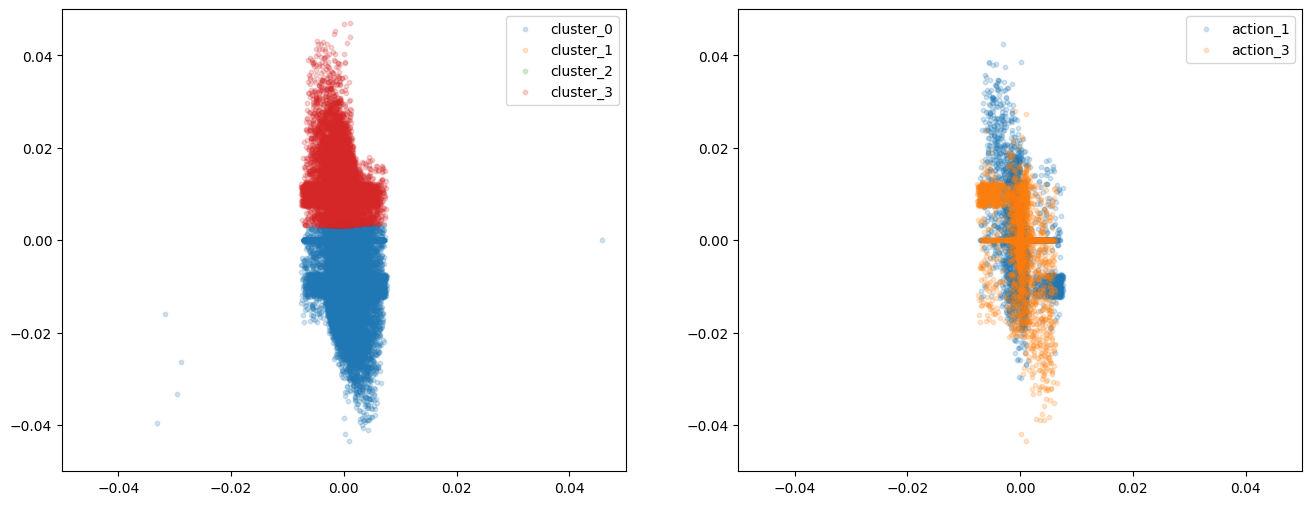

In [178]:
kmeans = KMeans(n_clusters=num_c)

# kmeans.fit(delta_s_r)
# result = kmeans.predict(delta_s_r)
result = kmeans.fit_predict(delta_s[0:100000, [0,2]])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for n in range(num_c):
    idx = np.where(result == n)
    plt.scatter(delta_s[0:100000, [0, 2]][idx,0], delta_s[0:100000, [0, 2]][idx,1], s=10, alpha=0.2, label=f'cluster_{n}')
    # plt.scatter([n]*len(idx[0]), delta_s[0:100000,5][idx], s=10, alpha=0.2, label=f'cluster_{n}')
plt.legend()
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

plt.subplot(1,2,2)
n_action = len(np.unique(action))
# for n in range(n_action):
for n in [1,3]:
    idx = np.where(action[0:100000] == n)
    plt.scatter(delta_s[0:100000, [0, 2]][idx,0], delta_s[0:100000, [0, 2]][idx,1], s=10, alpha=0.2, label=f'action_{n}')
    # plt.scatter([n]*len(idx[0]), delta_s[0:100000,5][idx], s=10, alpha=0.2, label=f'action_{n}')
plt.legend()
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

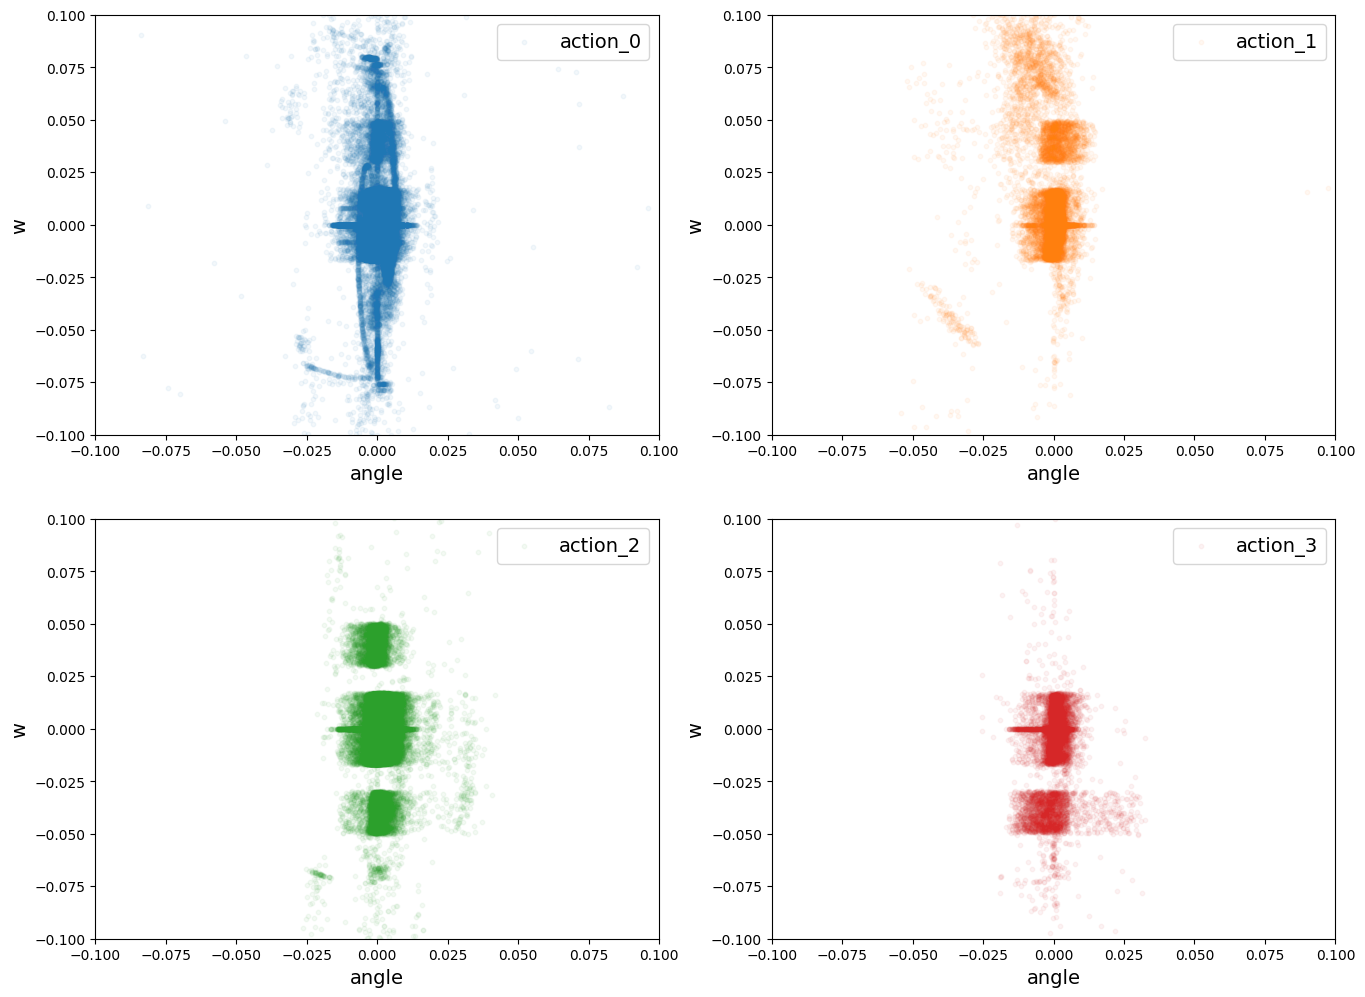

In [195]:
dict_param = {0:'pos_x', 1:'pos_y', 2:'v_x', 3:'v_y', 4:'angle', 5:'w'}
param=[4, 5]

plt.figure(figsize=(16,12))
n_action = len(np.unique(action))
for n in range(n_action):
    plt.subplot(2,2,n+1)
    idx = np.where(action[0:-1] == n)
    plt.scatter(delta_s[0:-1, param][idx,0], delta_s[0:-1, param][idx,1], s=10, alpha=0.05, label=f'action_{n}', color = plt.cm.tab10(n))
    # plt.scatter([n]*len(idx[0]), delta_s[0:-1,5][idx], s=10, alpha=0.2, label=f'action_{n}')
    plt.legend(fontsize=14)
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.xlabel(dict_param[param[0]], fontsize=14)
    plt.ylabel(dict_param[param[1]], fontsize=14)

In [202]:
ylim = max(np.max(delta_s[:, param[0]]), abs(np.min(delta_s[:, param[0]])))

In [203]:
ylim

0.64074427

In [199]:
dict_param = {0:'pos_x', 1:'pos_y', 2:'v_x', 3:'v_y', 4:'angle', 5:'w'}
len(dict_param)

6

In [200]:
l = ['a','b','c','d','e','f']
d = {}
for i in range(len(l)):
    d[i] = l[i]

In [201]:
d

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f'}

# Model load test

In [15]:
from b_policy.model import PolicyNetwork

path = os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'train', 'model_23')
with open(os.path.join(path, 'config.yaml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = PolicyNetwork(
    n_state=len(config['target_cols']),
    n_latent_action=config['n_latent_action'],
    units=config['units'],
    layer_num=config['layer_num'],
    batch_size=1
)
model.build_graph()
model.load_weights(os.path.join(path, 'best_weights'))

In [29]:
data_path = os.path.join(os.getcwd(), 'data', 'row', 'LunarLander-v2', 'expert_data_0')
with open(os.path.join(data_path, 'senario_0.json')) as f:
    data = json.load(f)

state = [data['pos_x'], data['pos_y'], data['v_x'], data['v_y'], data['angle'], data['w']]
state = np.transpose(state)
max = np.array([1.5, 1.5, 5., 5., 3.14, 5.])
min = np.array([-1.5, -1.5, -5., -5., -3.14, -5.])
state = np.divide(np.subtract(state, min), np.subtract(max, min))
s_next, s = state[1:,:], state[:-1,:]
delta_s = s_next - s

In [84]:
z_p, delta_s_hat = model(s[1:2])

In [85]:
delta_s_max = tf.multiply(tf.reshape(delta_s_hat, (3, 6)), tf.expand_dims(tf.one_hot(tf.argmax(tf.reshape(z_p, (3,)), axis=-1), 3), axis=-1))

In [86]:
tf.reduce_sum(delta_s_max, axis=0)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.00250435, -0.00268843,  0.0012047 , -0.00036039,  0.00013874,
       -0.00165592], dtype=float32)>

In [87]:
delta_s[1]

array([-2.03250286e-03, -2.49127547e-03,  1.14588737e-03, -2.69287825e-03,
        9.39330762e-05, -4.59514586e-03])

In [2]:
p = os.path.join(os.getcwd(), 'data/preprocessed/LunarLander-v2/expert_data_0/policy/data_1/max_0.02.npy')
max = np.load(p)

# Gym

In [ ]:
import gym
from stable_baselines3 import DQN

env = gym.make('LunarLander-v2', render_mode = "human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("runs/dqn_lunarlander")

obs = env.reset()
for i in tqdm(range(1000)):
    action, _states = model.predict(obs[0], deterministic=True)
    obs = env.step(action)
    env.render()

In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = DQN("MlpPolicy", env, verbose=1, gamma=0.99, learning_rate=0.0001)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e5), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/expert/dqn_lunar")
del model  # delete trained model to demonstrate loading

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1,
            gamma=0.95, n_steps=2048, ent_coef=0.01, learning_rate=2.5e-4, vf_coef=0.5)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e6), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/ppo_lunar")

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


# Evaluate the agent
eval_env = gym.make('LunarLander-v2')
model = PPO.load("runs/expert/lunar_lander/ppo-LunarLander-v2")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()
for i in range(1000):
    action, _state = model.predict(obs[0])
    # obs, reward, done, info = eval_env.step(action)
    obs = eval_env.step(action)
    eval_env.render()
    if obs[2]:
        obs = eval_env.reset()
eval_env.close()

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


mean_reward=267.81 +/- 25.41805570634785


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/envs/box2d/lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward=264.20 +/- 13.744305420570258


In [21]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

vec_env = model.get_env()
obs = vec_env.reset()

state_list = []
action_list = []

for i in range(50):
    action, _states = model.predict(obs, deterministic=True)  # 상태 저장 옵션 추가
    obs, rewards, dones, info = vec_env.step(action)
    state_list.append(obs[0])
    action_list.append(action)
    vec_env.render()
    if dones:
        break

vec_env.close()

state_list = np.array(state_list, dtype=np.float32)

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
def serialize(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

dict_state = {'pos_x' : list(state_list[:,0]),
            'pos_y' : list(state_list[:, 1]),
            'v_x' : list(state_list[:, 2]),
            'v_y' : list(state_list[:, 3]),
            'angle' : list(state_list[:, 4]),
            'w' : list(state_list[:, 5]),
            'is_grounded_left' : list(state_list[:, 6]),
            'is_grounded_right' : list(state_list[:, 7]),
            'action' : action_list
            }

num = len(glob(os.path.join(os.getcwd(), 'data', 'lunar_lander', 'expert_data*')))
save_path = os.path.join(os.getcwd(), 'data', 'lunar_lander')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(os.path.join(save_path, f'expert_data_{num}.json'), 'w') as f:
    json.dump(dict_state, f, default=serialize)

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

env = gym.make("LunarLander-v2")
env.reset()

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

eval_env = gym.make('LunarLander-v2')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()
env.close()

2024-05-12 20:01:58.129111: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 20:01:58.856935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=222.48 +/- 72.24385949967981


ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [3]:
base_path = os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'train')
model_paths = glob(os.path.join(base_path, 'model*'))

In [13]:
for p in model_paths:
    config_path = os.path.join(p, 'config.yaml')
    with open(config_path, 'r') as file:
        config_data = yaml.safe_load(file) or {}

    if "seq" in config_data.keys():
        continue
    else:
        config_data['seq'] = 1
        with open(config_path, 'w') as file:
            yaml.dump(config_data, file, default_flow_style=False)

In [14]:
dict_r.keys()

dict_keys(['pos_x', 'pos_y', 'v_x', 'v_y', 'angle', 'w', 'is_grounded_left', 'is_grounded_right', 'action'])

# Result

## Test result

### LunarLander-v2

In [297]:
columns = ['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()))
    rel_metrics.append(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_138 : [0.01051717 0.01503269 0.2541356  0.53735337 0.02521466 0.29029058]
model_14 : [0.00918446 0.01691396 0.28541829 0.57191754 0.03293714 0.2738518 ]
model_139 : [0.01205834 0.01314422 0.26023208 0.53666964 0.02931509 0.30881407]
model_135 : [0.00644281 0.0100741  0.24242683 0.50164498 0.02097769 0.29139755]
model_9 : [0.02230878 0.02973103 0.36138248 0.90850353 0.06033743 0.28664069]
model_25 : [0.0809555  0.18688706 0.92772311 0.67170533 0.46517581 0.46554757]
model_157 : [0.54143228 0.36922181 2.06829482 7.56163476 0.67584977 2.6606325 ]
model_1 : [0.0152649  0.02260842 0.30955133 0.58621427 0.09220973 0.30331555]
model_144 : [0.00278977 0.00895898 0.21427626 0.38419378 0.05621793 0.24999582]
model_33 : [0.03344037 0.02734042 0.28485757 0.56542419 0.03474196 0.30271221]
model_156 : [0.07866598 0.01705319 0.26028635 0.51084008 0.03296241 0.26882413]
model_145 : [0.00569292 0.00401999 0.21120757 0.29083431 0.01653291 0.2802266 ]
model_147 : [0.00420824 0.00817979 0.22478365 0

### MountainCar-v0

In [292]:
columns = ['rel_metric_pos', 'rel_metric_v']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[['rel_metric_pos', 'rel_metric_v']].mean()))
    rel_metrics.append(np.array(df[['rel_metric_pos', 'rel_metric_v']].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_5 : [0.04503561 6.46330495]
model_14 : [0.57196184 0.44129296]
model_7 : [0.05625343 4.09214545]
model_8 : [0.01494431 0.22931159]
model_9 : [0.00576739 0.71844464]
model_1 : [0.01974895 0.77497903]
model_11 : [0.12261195 5.30965225]
model_4 : [0.08639795 1.81857016]
model_12 : [0.06220839 0.32292797]
model_17 : [0.01811864 0.20643105]
model_0 : [0.00623576 0.03539182]
model_13 : [0.08804475 9.17461856]
model_6 : [2.92547792e-02 6.28270190e+01]


### CartPole-v1

In [299]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
rel_metrics = []
metrics = []
models = []
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'CartPole-v1', 'test', 'model_*', 'test_result*'))
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    models.append(p.split(os.sep)[-2])
    print(np.array(df[columns].mean()))
    rel_metrics.append(np.array(df[columns].mean()))
    metrics.append([df['test_metric'].mean()])

df_rel_metrics = pd.DataFrame(np.array(rel_metrics), columns=columns)
df_models = pd.DataFrame(models, columns=['model'])
df_metrics = pd.DataFrame(np.array(metrics), columns=['avg_test_metric'])
df_results = pd.concat([df_models, df_metrics, df_rel_metrics], axis=1)
df_results.to_csv('df_results.csv', index=False)

model_5 : [0.85499581 0.51802394 4.21275765 0.5302386 ]
model_8 : [0.6059253  0.44588998 2.85839256 0.45577663]
model_9 : [0.00527628 0.0020844  0.00972438 0.00208685]
model_1 : [0.41969327 0.46739936 3.2670567  0.47641242]
model_2 : [0.24144586 0.42392215 3.95194743 0.43004921]
model_4 : [1.11925909 0.4410304  5.6452401  0.44783798]
model_3 : [0.13485359 0.44151563 3.78400826 0.44876373]
model_0 : [0.68520616 0.46361189 3.844549   0.47401961]
model_13 : [0.0210717  0.00712102 0.03105978 0.00713591]
model_6 : [2.13076634 0.49603597 4.90616614 0.50626545]
model_10 : [0.03946089 0.00925274 0.01653859 0.00926368]


### test latent action distribution

([<matplotlib.axis.XTick at 0x75a0fb968be0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

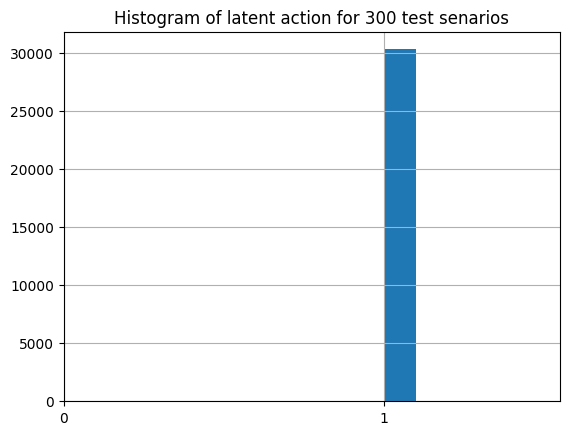

In [243]:
df['test_z'].hist()
plt.title('Histogram of latent action for 300 test senarios')
plt.xticks([0,1])

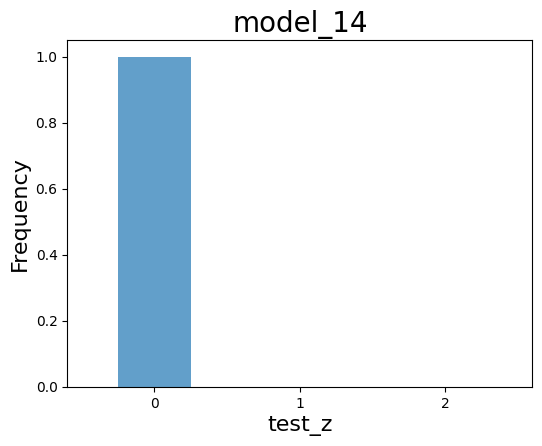

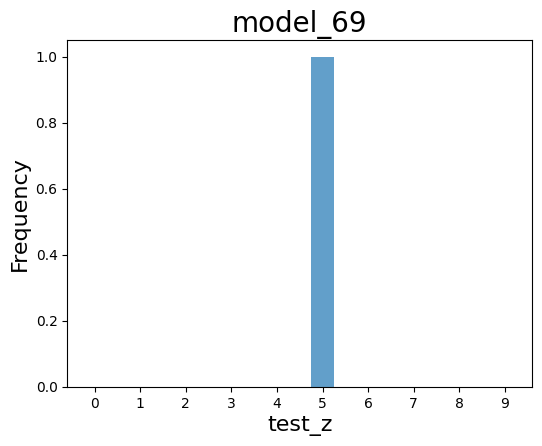

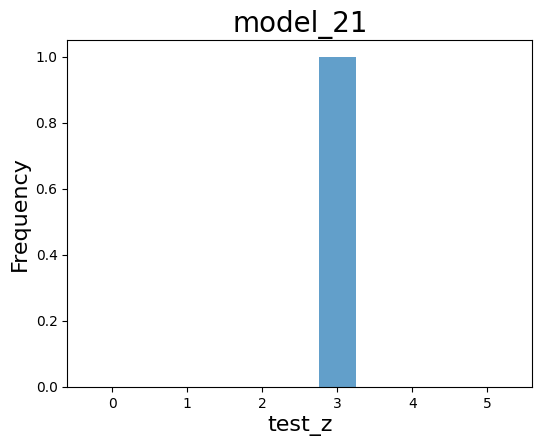

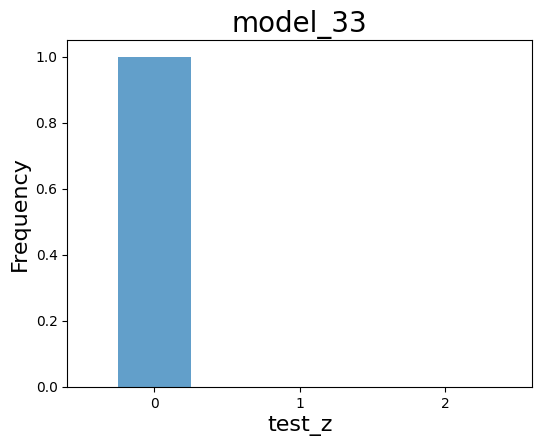

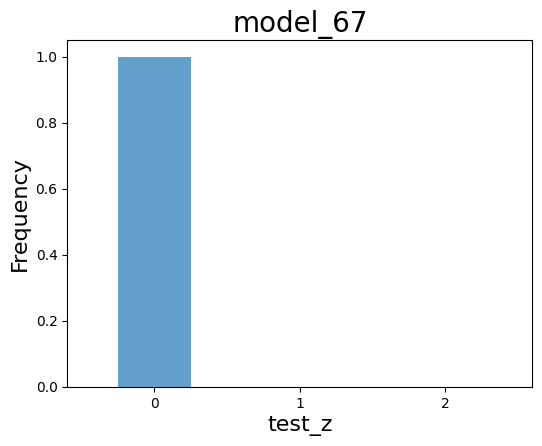

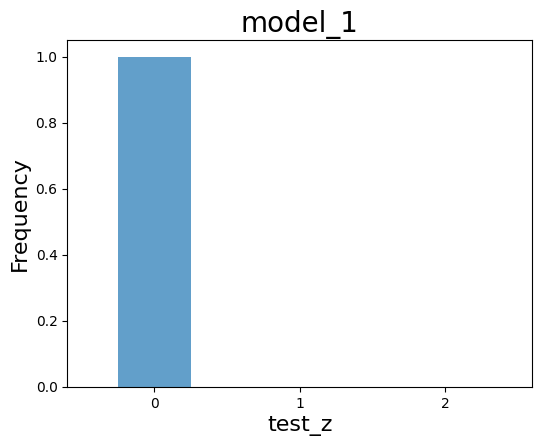

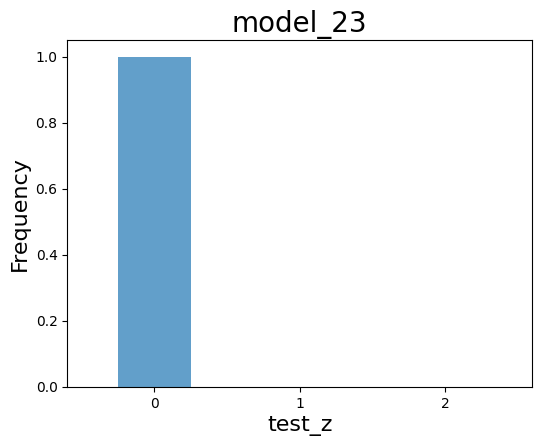

In [ ]:
for p in paths_best:
    df = pd.read_csv(p)
    num = extract_number_after_p(p.split(os.sep)[-1])
    plt.figure(figsize=(6, 4.5))
    plt.hist(df['test_z'], bins=np.arange(-0.5, num, 1), alpha=0.7, rwidth=0.5, density=True)
    # plt.title(f'Histogram of test_z : {p.split(os.sep)[-2]}, n_latent_action = {num}', fontsize=16)
    plt.title(p.split(os.sep)[-2], fontsize=20)
    plt.xlabel('test_z', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(np.arange(0, num, 1))
    plt.xlim(-0.6, num-0.4)
    plt.show()

## Train result : Policy

### MountainCar-v0

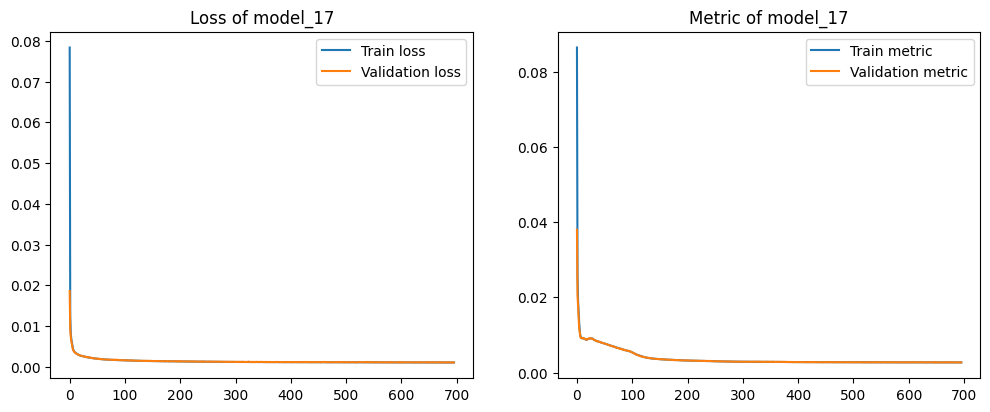

In [293]:
columns = ['rel_metric_pos', 'rel_metric_v']
for i in range(1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'policy', 'MountainCar-v0', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss_step = np.array(dict_train['loss_total'])
    train_metric_step = np.array(dict_train['metric'])
    train_epochs = np.array(dict_train['epochs'])
    val_loss_step = np.array(dict_val['loss_total'])
    val_metric_step = np.array(dict_val['metric'])
    val_epochs = np.array(dict_val['epochs'])

    train_loss = [np.mean(train_loss_step[np.where(train_epochs == e)]) for e in range(np.max(dict_train['epochs']))]
    val_loss = [np.mean(val_loss_step[np.where(val_epochs == e)]) for e in range(np.max(dict_val['epochs']))]
    train_metric = [np.mean(train_metric_step[np.where(train_epochs == e)]) for e in range(np.max(dict_train['epochs']))]
    val_metric = [np.mean(val_metric_step[np.where(val_epochs == e)]) for e in range(np.max(dict_val['epochs']))]

    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    # plt.ylim(0, 0.05)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(f"Metric of model_{i}")
    plt.plot(train_metric, label='Train metric')
    plt.plot(val_metric, label='Validation metric')
    plt.legend()
    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result.png'))

## Train result : Action Remap

### CartPole-v1

In [319]:
columns = ['rel_metric_pos', 'rel_metric_v', 'rel_metric_angle', 'rel_metric_w']
for i in range(2,3,1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'CartPole-v1', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss = np.array(dict_train['loss'])
    train_score = np.array(dict_train['score'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_loss = np.array(dict_val['loss'])

    plt.figure(figsize=(12,9))
    plt.subplot(2,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.ylim(0,1)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Score of model_{i}")
    plt.plot(train_score, label='Train score')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f"Metric of model_{i}")
    plt.plot(val_metric, label='Validation metric')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title(f"Score of model_{i}")
    plt.plot(val_score, label='Validation score')
    plt.legend()

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result.png'))

KeyError: 'loss'

In [310]:
columns = ['rel_metric_pos', 'rel_metric_v']
for i in range(2,3,1):
    paths_train = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'train', f'model_{i}', 'train_results.json')
    paths_val = os.path.join(os.getcwd(), 'runs', 'action_remap', 'MountainCar-v0', 'train', f'model_{i}', 'validation_results.json')
    with open(paths_train) as f:
        dict_train = json.load(f)
    with open(paths_val) as f:
        dict_val = json.load(f)
    train_loss = np.array(dict_train['loss'])
    train_score = np.array(dict_train['score'])
    val_score = np.array(dict_val['score'])
    val_metric = np.array(dict_val['metric'])
    val_loss = np.array(dict_val['loss'])

    plt.figure(figsize=(12,9))
    plt.subplot(2,2,1)
    plt.title(f"Loss of model_{i}")
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.ylim(0,1)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f"Score of model_{i}")
    plt.plot(train_score, label='Train score')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f"Metric of model_{i}")
    plt.plot(val_metric, label='Validation metric')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title(f"Score of model_{i}")
    plt.plot(val_score, label='Validation score')
    plt.legend()

    plt.savefig(os.path.join(os.path.dirname(paths_train), 'result.png'))

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]], dtype=float32)>

In [318]:
a = tf.constant([[1,2,3,4], [4,5,6,7]], dtype=tf.float32)
b = tf.constant([[5,5,6,6], [1,1,2,2]], dtype=tf.float32)
tf.norm(tf.subtract(a,b), axis=-1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.164414, 8.124038], dtype=float32)>